# Zillow Regression Project

### Project Goals

- The goal of this project is to discover the main features affecting property tax assessed value for single family residences in three Southern California counties and to use these features to develop a machine learning model that better predicts future home values for the most commonly sold homes than Zillow's current model.

- My initial hypothesis is that the size of the home in square feet, the number of bedrooms and bathrooms, and the location are the primary drivers of home value.

- Initial questions:
    - What is the relationship between square feet and tax value? Does the size of the home have a large impact on the overall tax assessment?
    - Which county has the most valuable properties? Can that value be determined by the year the home was built?
    - Does the number of bedrooms have an effect on tax value? Number of bathrooms? Total number of bedrooms and bathrooms?

### Project Planning

- Acquire the dataset from the Codeup database using SQL
- Prepare the data with the intent to discover the main drivers of assessed tax value; clean the data and encode categorical features if necessary; ensure that the data is tidy
- Split the data into train, validate, and test datasets using a 60/20/20 split
- Explore the data:
    - Univariate, bivariate, and multivariate analyses; statistical tests for significance, find the three primary features affecting assessed tax value
    - Create graphical representations of the analyses
    - Answer questions about the data
    - Document findings
    - Train and test at least three models:
        - Establish a baseline
    - Select key features and train multiple linear regression models
    - Test the model on the validate set, adjust for overfitting if necessary
    - Select the best model for the project goals:
        - Determine which model performs best on the validate set
    - Test and evaluate the model:
        - Use the model on the test set and evaluate its performance (RMSE, R2, etc.)
        - Visualize the data using an array of probabilities on the test set
    - Document key findings and takeaways, answer the questions
    
### Executive Summary

- After running four models on my train and validate sets, I decided to use the polynomial linear regression model because it provided the lowest RMSE and highest r2 score overall.

- I used the eight most significant features for assessed tax value (bathrooms, square feet of the home, Los Angeles County, total number of bedrooms and bathrooms, lot size, year built, the difference in lot size and home size, and the zip code). I selected a degree multiplier of 2. The RMSE of the selected model was 133682 on train, 135575 on validate, and 134578 on test. The test r2 score was .20.

- Takeaways: the biggest drivers of tax value are the number of bathrooms, the size of the home in square feet, and the number of bedrooms. The addition of zip code, Los Angeles County, total bedrooms and bathrooms, and lot size excluding home square footage decreased the root mean squared error and raised the explained variance score. The models all performed above the baseline RMSE. 

## Acquire and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import os
import wrangle
import explore
import model
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [2]:
# acquire and prepare the zillow dataset using wrangle function
df = wrangle.wrangle_zillow()

In [3]:
# split the data
train, validate, test = wrangle.split_data(df)

In [4]:
# verify 60/20/20 split
train.shape, validate.shape, test.shape

((21567, 15), (7190, 15), (7190, 15))

### Acquisition and Preparation Takeaways

- The dataset was acquired from the Codeup database using a SQL query.

- Data was limited to homes with a transaction in 2017, homes with more than 0 and less than 6 bedrooms, more than 0 and less than 5 bathrooms, between 700 and 11,000 square feet, tax value of 100,000 to 700,000 dollars, and lot sizes between 1000 and 12,000 square feet. All observations with null values were removed. 

- FIPS was encoded and bedrooms, bathrooms, and year were converted to integers. 

- The cleaned dataset has 35958 observations and 15 columns. All columns are integers or floats except transaction date.

- The dataset has been split into train, validate, and test sets using a 60/20/20 split.

## Exploratory Data Analysis

#### Does the number of bedrooms have an effect on tax value? Number of bathrooms? Total number of bedrooms and bathrooms?

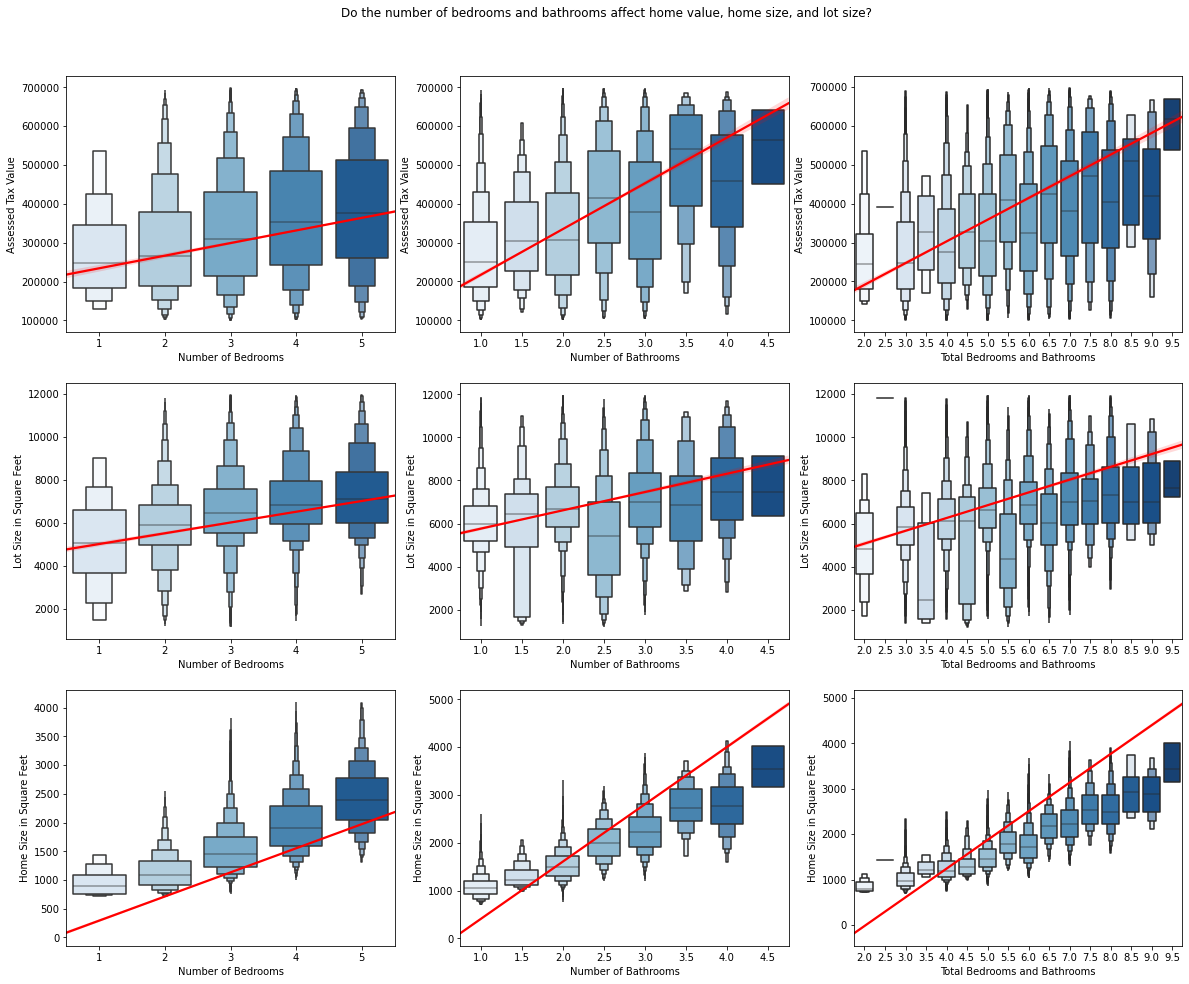

In [6]:
# function for graphing categorical relationships with regression lines
explore.plot_vars(train)

#### Which county has the most valuable properties? Can that value be determined by the year the home was built?

#### What is the relationship between size, year built, and tax value? Does the size of the home have a large impact on the overall tax assessment?

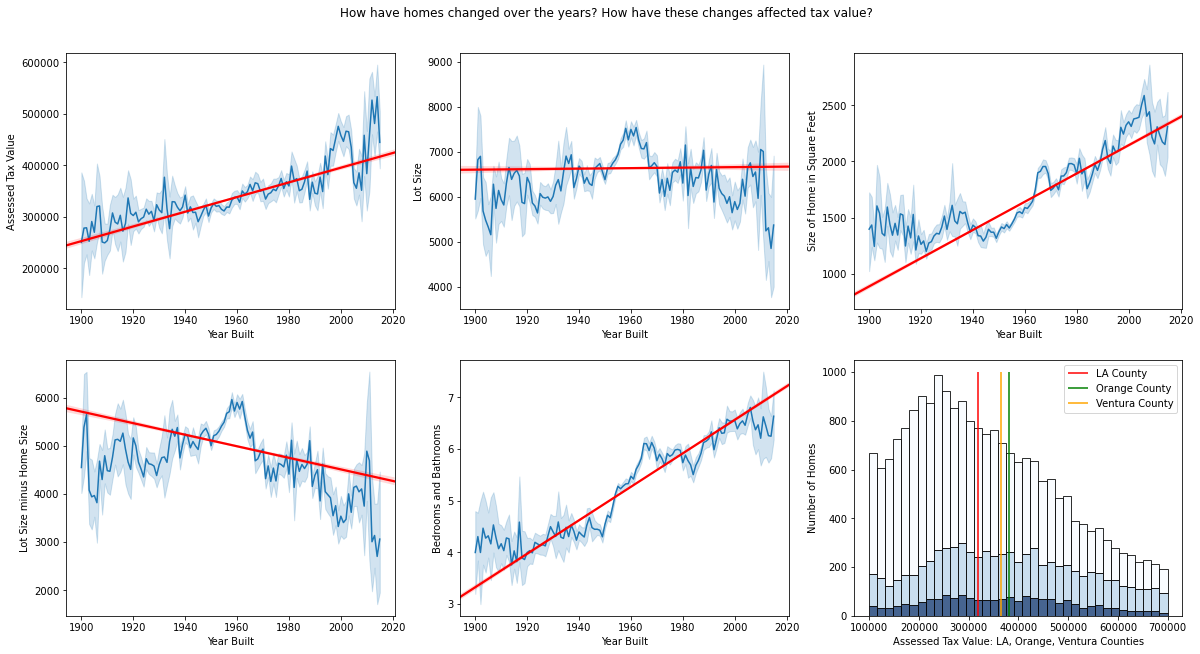

In [7]:
# graph the relationships between time and other features; show the average tax value for each county
explore.plot_time_vars(train)

### Statistical Testing

- Is there a relationship between the size of the home and the tax value?
- H0: There is no linear correlation between the size of the home and the assessed tax value.
- Ha: There is a linear correlation between the size of the home and the assessed tax value.

In [8]:
# function for pearson test, which outputs the correlation coefficient and the corresponding p-value
explore.pearson_test(train.sqft, train.tax_value)

We reject the null hypothesis.


(0.3300296419538223, 0.0)

- Correlation statistical test shows that there is a relationship between home size and tax value.

- Is there a relationship between the number of bathrooms and the tax value of the home?
- H0: There is no linear correlation between the number of bathrooms and the tax value of the home.
- Ha: There is a linear correlation between the number of bathrooms and the tax value of the home.

In [9]:
# function for pearson test, which outputs the correlation coefficient and the corresponding p-value
explore.pearson_test(train.bathrooms, train.tax_value)

We reject the null hypothesis.


(0.2753364923387785, 0.0)

- Correlation statistical test shows that there is a relationship between the number of bathrooms and the assessed tax value.

Findings: 

- There is a positive relationship between the number of bathrooms and the tax assessed value of the home. 
- There is also a positive relationship between the number of bedrooms and the tax assessed value of the home.
- Lot sizes did not change much overall between 1900 and 2016, but the total square feet of homes increased significantly over time. This resulted in an overall decrease of the lot size minus the overall square footage of the home. This is not taking into account whether the homes have multiple levels, however.
- Tax value is lowest in Los Angeles County, followed by Ventura County, with Orange County having the highest tax assessments overall.


## Modeling

In [10]:
# list of features to be used in the model 
cols = ['bathrooms','sqft','fips_6037','bed_bath','lot_size','year','lot_minus_home','zipcode']
# assign features and target to variables for train
X_train, y_train = train[cols], train[['tax_value']]
# assign features and target to variables for validate
X_validate, y_validate = validate[cols], validate[['tax_value']]
# assign features and target to variables for test
X_test, y_test = test[cols], test[['tax_value']]
# calculate the baseline prediction using the mean
baseline = train.tax_value.mean()
# create a new column in train for the baseline predictions
train['baseline'] = baseline
# assign target to y for use in later functions
y = train.tax_value

Scale the selected features using the MinMax Scaler:

In [11]:
# scale the data using the minmax scaler function in wrangle.py
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.minmax_scaler(X_train, X_validate, X_test)

Calculate the baseline RMSE:

In [12]:
# calculate and output the RMSE for the baseline prediction
RMSE_baseline = sqrt(mean_squared_error(y_train, train.baseline))
RMSE_baseline

149721.77521543583

Fit and evaluate four selected models:

In [13]:
# model 1 is a 2nd degree polynomial linear regression model saved as a function in model.py
m1 = model.poly_lm(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, train, 2)
# model 2 is an OLS linear regression model from model.py
m2 = model.lrm(X_train_scaled, X_validate_scaled, y_train, y_validate, train)
# model 3 is a tweedie regressor model from model.py
m3 = model.glm_model(X_train_scaled, X_validate_scaled, y_train, y_validate, train, 1, 2)
# model 4 is a lasso lars model using a function in model.py
m4 = model.lasso_lars_model(X_train_scaled, X_validate_scaled, y_train, y_validate, train, 1)

Here is how each model performed:

In [14]:
# use the function for calculating model performance for all four models
model.model_performance(m1,m2,m3,m4)

,Model,Train RMSE,Validate RMSE,r2 score,Better than Baseline,RMSE Difference
0,Poly Linear Regression,133682.708954,135575.248473,0.202776,True,16039.066262
1,OLS,137776.329206,139879.266971,0.153203,True,11945.446009
2,Tweedie Regressor,138115.253387,140403.920897,0.149032,True,11606.521828
3,Lasso Lars,137778.314240,139879.304953,0.153179,True,11943.460975


#### Model Findings

- Seven features were selected for modeling: bathrooms, square feet, Los Angeles County, total bedrooms and bathrooms, lot size, year built, and the square footage of the lot minus the square footage of the home.
- All four models performed above the baseline RMSE with the selected features using four scalers: MinMax, Quantile, Standard, and Robust.
- The Linear Regression Model with squared polynomial features performed best, with an RMSE of 133,682 on train and 135,575 on validate with an r^2 score of .20. The minmax scaler was used for scaling.


## Select and Test the Best Model


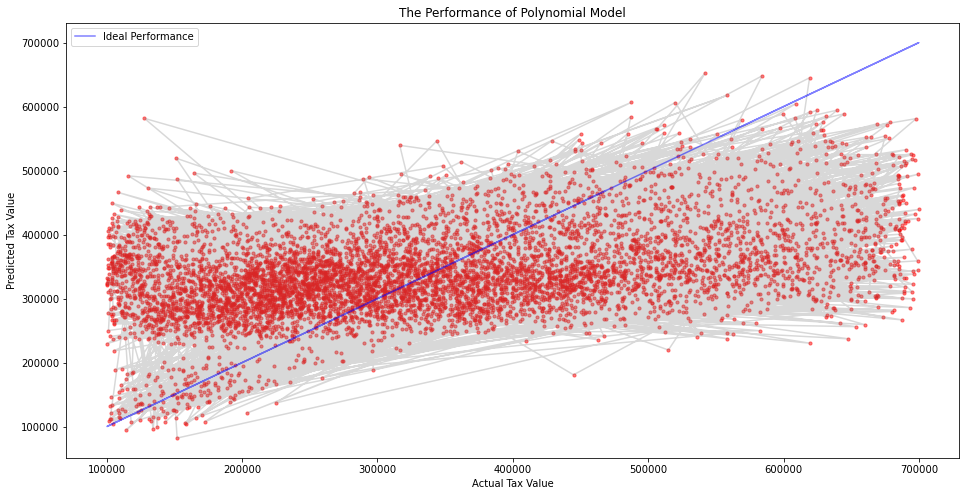

(134578.49762731272, 0.1964116837621377)

In [15]:
# performance of selected model on the test set; outputs RMSE and r2 score after graph
test_rmse = model.test_poly_lm(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, train, 2)
test_rmse

In [16]:
# difference between the baseline RMSE and the test RMSE
RMSE_baseline - test_rmse[0]

15143.277588123106

#### Test Findings:

- The linear regression with squared polynomial features performed above baseline with an RMSE of 134,578, which was 15,143 dollars less error than the baseline prediction.
- The model difference between train and test was less than 1000, indicating that the model was not overfit to the training dataset.

## Conclusions and Recommendations

- The selected model has a lower root mean squared error than baseline predictions, but can only account for 20% of the variance in home values. Bathrooms are the most significant single feature that affects home value, but there are many other factors to consider in order to get a better prediction.
- I recommend obtaining accurate data on the number of stories the home has, as well as parking structures or spaces in order to more accurately predict home value. I also recommend adding crime rates and school ratings to the dataset to see if it has any effect on the model's performance. We could also use the type of single family residence (house, condo, townhome, etc.) in order to tune the model. We can also investigate how much the tax assessed value increased annually over the last 50 years in order to make better predictions.
- If I had more time, I would do more feature engineering on the zip codes to see if there is a relationship between that and home value, home size, and home age. I would also test non-linear regression models to see if they perform better on the data we currently have.